## Isolation ForestによるAnomaly Detection

参考
- Blog: [Anomaly Detection with Isolation Forests using H2O](https://www.h2o.ai/blog/anomaly-detection-with-isolation-forests-using-h2o/)
- Notebook sample: [Anomaly Detection](https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/anomaly-detection/anomaly_detection.ipynb)

In [1]:
import h2o
print(h2o.__version__)

3.30.0.1


In [3]:
h2o.init(url='http://54.236.239.208:54321')

Checking whether there is an H2O instance running at http://54.236.239.208:54321 . connected.


H2O_cluster_uptime:,4 mins 00 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,"1 year, 1 month and 17 days !!!"
H2O_cluster_name:,Puddle
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,49.72 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


### データ

利用データ: [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud)
- The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 

特徴量
- Time : Seconds elapsed between each transaction
- V1~V28 : Principal components obtained with PCA (秘匿情報にPCAを実施したもの)
- Amount : Transaction Amount

ターゲット
- Class : 1:Fraud, 0:Not Fraud

284,807のトランザクション中、492件のみがFraud（0.17%）の不均衡データ

In [81]:
frame = h2o.import_file("/data/my_sample/creditcard.csv")
frame.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(284807, 31)

In [82]:
type(frame)

h2o.frame.H2OFrame

[H2OFrame](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html#h2oframe)

In [83]:
frame.head()

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.35981,-0.0727812,2.53635,1.37816,-0.338321,0.462388,0.239599,0.0986979,0.363787,0.0907942,-0.5516,-0.617801,-0.99139,-0.311169,1.46818,-0.470401,0.207971,0.0257906,0.403993,0.251412,-0.0183068,0.277838,-0.110474,0.0669281,0.128539,-0.189115,0.133558,-0.0210531,149.62,0
0,1.19186,0.266151,0.16648,0.448154,0.0600176,-0.0823608,-0.078803,0.0851017,-0.255425,-0.166974,1.61273,1.06524,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.0690831,-0.225775,-0.638672,0.101288,-0.339846,0.16717,0.125895,-0.0089831,0.0147242,2.69,0
1,-1.35835,-1.34016,1.77321,0.37978,-0.503198,1.8005,0.791461,0.247676,-1.51465,0.207643,0.624501,0.0660837,0.717293,-0.165946,2.34586,-2.89008,1.10997,-0.121359,-2.26186,0.52498,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.0553528,-0.0597518,378.66,0
1,-0.966272,-0.185226,1.79299,-0.863291,-0.0103089,1.2472,0.237609,0.377436,-1.38702,-0.0549519,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.05965,-0.684093,1.96578,-1.23262,-0.208038,-0.1083,0.0052736,-0.190321,-1.17558,0.647376,-0.221929,0.0627228,0.0614576,123.5,0
2,-1.15823,0.877737,1.54872,0.403034,-0.407193,0.0959215,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.34585,-1.11967,0.175121,-0.451449,-0.237033,-0.0381948,0.803487,0.408542,-0.0094307,0.798278,-0.137458,0.141267,-0.20601,0.502292,0.219422,0.215153,69.99,0
2,-0.425966,0.960523,1.14111,-0.168252,0.420987,-0.0297276,0.476201,0.260314,-0.568671,-0.371407,1.34126,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.0581328,0.0686531,-0.0331938,0.0849677,-0.208254,-0.559825,-0.0263977,-0.371427,-0.232794,0.105915,0.253844,0.0810803,3.67,0
4,1.22966,0.141004,0.0453708,1.20261,0.191881,0.272708,-0.005159,0.0812129,0.46496,-0.0992543,-1.41691,-0.153826,-0.751063,0.167372,0.0501436,-0.443587,0.00282051,-0.611987,-0.045575,-0.219633,-0.167716,-0.27071,-0.154104,-0.780055,0.750137,-0.257237,0.0345074,0.00516777,4.99,0
7,-0.644269,1.41796,1.07438,-0.492199,0.948934,0.428118,1.12063,-3.80786,0.615375,1.24938,-0.619468,0.291474,1.75796,-1.32387,0.686133,-0.076127,-1.22213,-0.358222,0.324505,-0.156742,1.94347,-1.01545,0.0575035,-0.649709,-0.415267,-0.0516343,-1.20692,-1.08534,40.8,0
7,-0.894286,0.286157,-0.113192,-0.271526,2.6696,3.72182,0.370145,0.851084,-0.392048,-0.41043,-0.705117,-0.110452,-0.286254,0.0743554,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.0527357,-0.0734251,-0.268092,-0.204233,1.01159,0.373205,-0.384157,0.0117474,0.142404,93.2,0
9,-0.338262,1.11959,1.04437,-0.222187,0.499361,-0.246761,0.651583,0.0695386,-0.736727,-0.366846,1.01761,0.83639,1.00684,-0.443523,0.150219,0.739453,-0.54098,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.38505,-0.069733,0.0941988,0.246219,0.0830756,3.68,0


In [84]:
feature_names = frame.col_names[:30]   # 特徴量カラム名（30変数）

In [85]:
frame.describe()

Rows:284807
Cols:31




,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
type,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int
mins,0.0,-56.407509631329,-72.7157275629303,-48.3255893623954,-5.68317119816995,-113.743306711146,-26.1605059358433,-43.5572415712451,-73.2167184552674,-13.4340663182301,-24.5882624372475,-4.79747346479757,-18.6837146333443,-5.79188120632084,-19.2143254902614,-4.49894467676621,-14.1298545174931,-25.1627993693248,-9.49874592104677,-7.21352743017759,-54.497720494566,-34.8303821448146,-10.933143697655,-44.8077352037913,-2.83662691870341,-10.2953970749851,-2.60455055280817,-22.5656793207827,-15.4300839055349,0.0,0.0
mean,94813.85957508067,1.2262548514636384e-15,3.5446429300120796e-16,-1.328442755752275e-15,2.030984597736651e-15,1.0985199711028427e-15,1.500884844239349e-15,-5.875804496596601e-16,7.66409282164774e-17,-2.324774822566481e-15,2.213006802250785e-15,1.5328185643295479e-15,-1.2134813634275587e-15,9.037242785526292e-16,1.2214647934501085e-15,4.9561133579988715e-15,1.4465975200860108e-15,-3.704311530463074e-16,1.0154922988683254e-15,1.0490227049630343e-15,6.386744018039783e-16,1.532818564329548e-16,-3.4488417697414826e-16,2.5227638871257145e-16,4.469124126623338e-15,5.364864975153418e-16,1.6908904787760325e-15,-3.6434378765411323e-16,-1.241423368506483e-16,88.34961925093133,0.001727485630620034
maxs,172792.0,2.45492999121121,22.0577289904909,9.38255843282114,16.8753440335975,34.8016658766686,73.3016255459646,120.589493945238,20.0072083651213,15.5949946071278,23.7451361206545,12.0189131816199,7.8483920756446,7.12688295859376,10.5267660517847,8.87774159774277,17.3151115176278,9.25352625047285,5.04106918541184,5.59197142733558,39.4209042482199,27.2028391573154,10.5030900899454,22.5284116897749,4.58454913689817,7.51958867870916,3.5173456116238,31.6121981061363,33.8478078188831,25691.16,1.0
sigma,47488.14595456615,1.958695803857486,1.6513085794769975,1.5162550051777715,1.4158685749409203,1.3802467340314393,1.3322710897575754,1.237093598182666,1.1943529026692037,1.098632089224319,1.088849765402517,1.0207130277115584,0.9992013895301448,0.9952742301251534,0.958595611257064,0.9153160116104392,0.8762528873883701,0.8493370636743892,0.8381762095288414,0.8140405007685786,0.7709250248871169,0.7345240143713132,0.7257015604409116,0.6244602955949902,0.6056470678271602,0.5212780705409424,0.48222701326105727,0.4036324949650307,0.3300832641602509,250.12010924018855,0.041527189635465055
zeros,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1825,284315
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,149.62,0.0
1,0.0,1.19185711131486,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.166974414004614,1.61272666105479,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.463917041022171,-0.114804663102346,-0.183361270123994,-0.145783041325259,-0.0690831352230203,-0.225775248033138,-0.638671952771851,0.101288021253234,-0.339846475529127,0.167170404418143,0.125894532368176,-0.00898309914322813,0.0147241691924927,2.69,0.0
2,1.0,-1.35835406159823,-1.34016307473609,1.77320934263119,0.379779593034328,-0.503198133318193,1.80049938079263,0.791460956450422,0.247675786588991,-1.51465432260583,0.207642865216696,0.624501459

In [86]:
frame.isna().any()

# 欠損なし

False

In [87]:
# Fraudの数
frame['Class'].sum()

492.0

In [88]:
# Fraudの割合
frame['Class'].sum() / frame.nrows

0.001727485630620034

### Isolation Forestによる異常検知

Doc: [Isolation Forest](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/if.html)  
Python API: [H2OIsolationForestEstimator](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oisolationforestestimator)

In [89]:
from h2o.estimators import H2OIsolationForestEstimator

In [90]:
mod_if = H2OIsolationForestEstimator()
mod_if

No model trained yet


In [91]:
mod_if.train(training_frame=frame, x=feature_names)

isolationforest Model Build progress: |███████████████████████████████████| 100%


In [92]:
mod_if

Model Details
H2OIsolationForestEstimator :  Isolation Forest
Model Key:  IsolationForest_model_python_1621548352308_3


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,33613.0,8.0,8.0,8.0,26.0,85.0,48.8




ModelMetricsAnomaly: isolationforest
** Reported on train data. **

Anomaly Score: 6.77997326038587
Normalized Anomaly Score: 0.05556230798333812

Scoring History: 


,,timestamp,duration,number_of_trees,mean_tree_path_length,mean_anomaly_score
0,,2021-05-20 22:55:49,0.007 sec,0.0,NaN,NaN
1,,2021-05-20 22:55:49,0.076 sec,1.0,6.737098,0.052580
2,,2021-05-20 22:55:49,0.120 sec,2.0,6.823679,0.029387
3,,2021-05-20 22:55:49,0.164 sec,3.0,6.840176,0.034248
4,,2021-05-20 22:55:49,0.211 sec,4.0,6.847873,0.030425
5,,2021-05-20 22:55:49,0.260 sec,5.0,6.824881,0.033677
6,,2021-05-20 22:55:49,0.306 sec,6.0,6.818659,0.032971
7,,2021-05-20 22:55:49,0.349 sec,7.0,6.837813,0.030684
8,,2021-05-20 22:55:49,0.394 sec,8.0,6.820855,0.036748
9,,2021-05-20 22:55:49,0.444 sec,9.0,6.816773,0.035849



See the whole table with table.as_data_frame()


In [93]:
# 学習済みのモデルを用いたスコアリング（スコアリング用データは学習に用いたもの）
score_if = mod_if.predict(frame)

isolationforest prediction progress: |████████████████████████████████████| 100%


In [94]:
score_if

predict,mean_length
0.0252525,6.9
0.0252525,6.9
0.111111,6.56
0.0606061,6.76
0.00505051,6.98
0.0454545,6.82
0.010101,6.96
0.186869,6.26
0.0959596,6.62
0.020202,6.92


predict: 正規化された異常値スコア（0~1の範囲）  
mean_length: 分岐数の平均

In [95]:
score_if.cor()  # 2変数の相関

# 両者は全く同じ情報を持つ

predict,mean_length
1,-1
-1,1


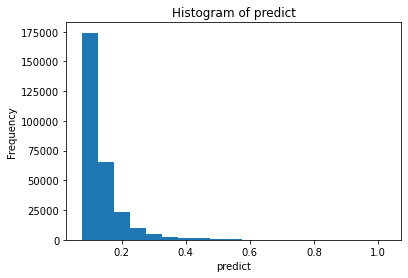

In [96]:
score_if['predict'].hist()

In [97]:
score_if['predict'].quantile()

Probs,predictQuantiles
0.01,0
0.1,0
0.25,0.010101
0.333,0.020202
0.5,0.0353535
0.667,0.0555556
0.75,0.0707071
0.9,0.131313
0.99,0.348485


### 精度検証

In [31]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [98]:
# pandas.DataFrameへ変換（ローカル環境上のオブジェクトにロード）
df_res = pd.concat([frame['Class'].as_data_frame(), score_if['predict'].as_data_frame()], axis=1)
df_res

,Class,predict
0,0,0.025253
1,0,0.025253
2,0,0.111111
3,0,0.060606
4,0,0.005051
...,...,...
284802,0,0.449495
284803,0,0.050505
284804,0,0.030303
284805,0,0.106061


In [142]:
actual = df_res['Class']   # 実測
anomaly_score = df_res['predict']  # 予測

[]

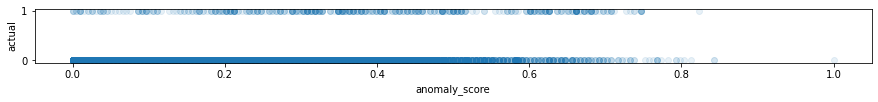

In [143]:
# 予実プロット
plt.figure(figsize=[15,1])
plt.scatter(anomaly_score, actual, alpha=0.1)
plt.xlabel('anomaly_score')
plt.ylabel('actual')
plt.plot()

In [119]:
anomaly_score.max()

1.0

In [113]:
# anomaly_score=1だが、actual=0のデータ
frame[anomaly_score.idxmax(), :]

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
166198,-35.5485,-31.8505,-48.3256,15.3042,-113.743,73.3016,120.589,-27.3474,-3.87242,-12.0055,6.8539,-9.18942,7.12688,-6.79594,8.87774,17.3151,-7.17381,-1.96804,5.50175,-54.4977,-21.6201,5.7123,-1.5811,4.58455,4.55468,3.41564,31.6122,-15.4301,25691.2,0


#### ROC曲線

In [128]:
fpr, tpr, threshold = roc_curve(actual, anomaly_score)

In [129]:
# AUC
auc_value = auc(fpr, tpr)
auc_value

0.9450088423909757

[]

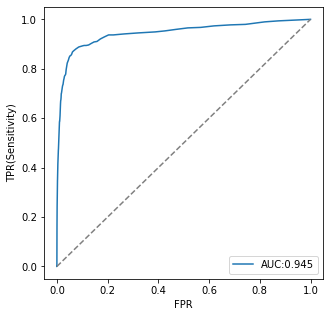

In [130]:
# ROC曲線
plt.figure(figsize=[5,5])
plt.plot(fpr, tpr, label="AUC:{:.3f}".format(auc_value))
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), '--', color='gray')    # 斜め４５度線
plt.xlabel('FPR')
plt.ylabel('TPR(Sensitivity)')
plt.legend(loc='lower right')
plt.plot()

**True Positive Rate (Sensitivity):** 実際に1のものを、1と予測できた割合  
**False Positive Rate:** 実際は0のものを、1と予測してしまった割合

#### Precision-Recall曲線
True Negative（0を0と予測）を考慮しないので、不均衡データに対して妥当なモデル評価方法となる

In [144]:
precision, tpr, threshold = precision_recall_curve(actual, anomaly_score)

In [145]:
pd.DataFrame({'precision':precision, 'tpr':tpr, 'threshold':[0, *threshold]})

# threshold=1において、precision=1と設定されているため、値が飛んでいるようになっていると考えられる

,precision,tpr,threshold
0,0.001727,1.000000,0.000000
1,0.001964,0.993902,0.000000
2,0.002086,0.989837,0.005051
3,0.002276,0.979675,0.010101
4,0.002466,0.977642,0.015152
...,...,...,...
157,0.200000,0.002033,0.803030
158,0.250000,0.002033,0.813131
159,0.000000,0.000000,0.823232
160,0.000000,0.000000,0.843434


In [133]:
# AUCPR
aucpr_score = np.trapz(y=precision, x=tpr)*-1     # x=tprが降順になっているので符号を入れ替える
aucpr_score

0.16404374759282025

[]

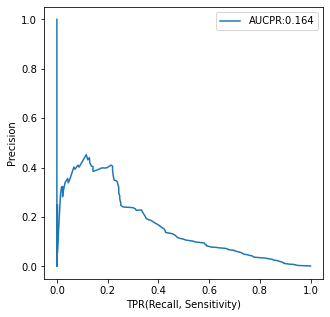

In [134]:
# Precision-Recall曲線
plt.figure(figsize=[5,5])
plt.plot(tpr, precision, label="AUCPR:{:.3f}".format(aucpr_score))
plt.xlabel('TPR(Recall, Sensitivity)')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.plot()

**Precision:** 1と予測して、実際に1だった割合  
**True Positive Rate (Recall, Sensitivity):** 実際に1のものを、1と予測できた割合

### モデルの解釈

代理モデル/Surrogate Model（予測値を目的変数とし、元の特徴量で予測、どの特徴量が効いているかを確認）を用いた解釈

In [155]:
# 正規化された異常値スコアを元データ（H2OFrame）に結合
frame['anomaly_score'] = score_if['predict']
print(frame.shape)
frame.head()

(284807, 32)


Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,anomaly_score
0,-1.35981,-0.0727812,2.53635,1.37816,-0.338321,0.462388,0.239599,0.0986979,0.363787,0.0907942,-0.5516,-0.617801,-0.99139,-0.311169,1.46818,-0.470401,0.207971,0.0257906,0.403993,0.251412,-0.0183068,0.277838,-0.110474,0.0669281,0.128539,-0.189115,0.133558,-0.0210531,149.62,0,0.0252525
0,1.19186,0.266151,0.16648,0.448154,0.0600176,-0.0823608,-0.078803,0.0851017,-0.255425,-0.166974,1.61273,1.06524,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.0690831,-0.225775,-0.638672,0.101288,-0.339846,0.16717,0.125895,-0.0089831,0.0147242,2.69,0,0.0252525
1,-1.35835,-1.34016,1.77321,0.37978,-0.503198,1.8005,0.791461,0.247676,-1.51465,0.207643,0.624501,0.0660837,0.717293,-0.165946,2.34586,-2.89008,1.10997,-0.121359,-2.26186,0.52498,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.0553528,-0.0597518,378.66,0,0.111111
1,-0.966272,-0.185226,1.79299,-0.863291,-0.0103089,1.2472,0.237609,0.377436,-1.38702,-0.0549519,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.05965,-0.684093,1.96578,-1.23262,-0.208038,-0.1083,0.0052736,-0.190321,-1.17558,0.647376,-0.221929,0.0627228,0.0614576,123.5,0,0.0606061
2,-1.15823,0.877737,1.54872,0.403034,-0.407193,0.0959215,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.34585,-1.11967,0.175121,-0.451449,-0.237033,-0.0381948,0.803487,0.408542,-0.0094307,0.798278,-0.137458,0.141267,-0.20601,0.502292,0.219422,0.215153,69.99,0,0.00505051
2,-0.425966,0.960523,1.14111,-0.168252,0.420987,-0.0297276,0.476201,0.260314,-0.568671,-0.371407,1.34126,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.0581328,0.0686531,-0.0331938,0.0849677,-0.208254,-0.559825,-0.0263977,-0.371427,-0.232794,0.105915,0.253844,0.0810803,3.67,0,0.0454545
4,1.22966,0.141004,0.0453708,1.20261,0.191881,0.272708,-0.005159,0.0812129,0.46496,-0.0992543,-1.41691,-0.153826,-0.751063,0.167372,0.0501436,-0.443587,0.00282051,-0.611987,-0.045575,-0.219633,-0.167716,-0.27071,-0.154104,-0.780055,0.750137,-0.257237,0.0345074,0.00516777,4.99,0,0.010101
7,-0.644269,1.41796,1.07438,-0.492199,0.948934,0.428118,1.12063,-3.80786,0.615375,1.24938,-0.619468,0.291474,1.75796,-1.32387,0.686133,-0.076127,-1.22213,-0.358222,0.324505,-0.156742,1.94347,-1.01545,0.0575035,-0.649709,-0.415267,-0.0516343,-1.20692,-1.08534,40.8,0,0.186869
7,-0.894286,0.286157,-0.113192,-0.271526,2.6696,3.72182,0.370145,0.851084,-0.392048,-0.41043,-0.705117,-0.110452,-0.286254,0.0743554,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.0527357,-0.0734251,-0.268092,-0.204233,1.01159,0.373205,-0.384157,0.0117474,0.142404,93.2,0,0.0959596
9,-0.338262,1.11959,1.04437,-0.222187,0.499361,-0.246761,0.651583,0.0695386,-0.736727,-0.366846,1.01761,0.83639,1.00684,-0.443523,0.150219,0.739453,-0.54098,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.38505,-0.069733,0.0941988,0.246219,0.0830756,3.68,0,0.020202


In [156]:
len(feature_names)

30

#### GLM
[Python API](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogeneralizedlinearestimator)

In [146]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [186]:
surrogate_glm = H2OGeneralizedLinearEstimator(lambda_=0)  # lambda_=0: 正則化を実施しない

In [187]:
surrogate_glm.train(training_frame=frame, x=feature_names, y='anomaly_score')

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [188]:
surrogate_glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1621548352308_9


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,None,30,30,1,py_45_sid_8535




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.0013853652816769042
RMSE: 0.03722049545179247
MAE: 0.02650366347727775
RMSLE: 0.032882559657879465
R^2: 0.7145215806555236
Mean Residual Deviance: 0.0013853652816769042
Null degrees of freedom: 284806
Residual degrees of freedom: 284776
Null deviance: 1382.107028210935
Residual deviance: 394.5617297785541
AIC: -1066229.0189581614

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective
0,,2021-05-21 00:04:08,0.000 sec,0,1382.10703,0.004853


代理モデルの当てはまりは、R2で見た場合71%

In [219]:
# 回帰係数の取得
# surrogate_glm.coef_norm()  ->  標準化された特徴量に対する回帰係数の推定結果
df_coeff = pd.DataFrame.from_dict(surrogate_glm.coef_norm(), orient='index').reset_index()
df_coeff.columns = ['Feature', 'Coeff']
df_coeff = df_coeff.drop(0, axis=0)   # Interceptを削除
df_coeff.head()

,Feature,Coeff
1,Time,0.001624
2,V1,-0.037150
3,V2,0.007307
4,V3,-0.013998
5,V4,0.006120


[]

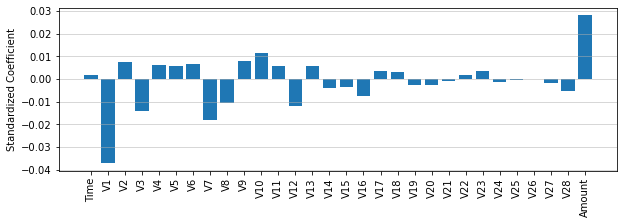

In [234]:
plt.figure(figsize=[10,3])
plt.bar(df_coeff['Feature'], df_coeff['Coeff'])
plt.xticks(rotation=90)
plt.ylabel('Standardized Coefficient')
plt.grid(linewidth=0.5, axis='y')
plt.plot()

V1（値が大きいと異常値スコアが低くなる）とAmount（値が大きいと異常値スコアが高くなる）が大きく貢献している

#### Decision Tree
[Python API](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2orandomforestestimator)  
Random Forrestを利用

In [358]:
from h2o.estimators import H2ORandomForestEstimator

In [365]:
surrogate_rf = H2ORandomForestEstimator(ntrees=1,     # 木１本
                                        max_depth=3,      # 分岐の深さ
                                        min_rows=10,      # リーフが必要とする最低データ数
                                        sample_rate=1,     # データサンプリングは100%（サンプリングを実施しない）
                                        mtries=len(feature_names))    # 分岐の候補変数の数（特徴量の数と同数にし、候補選択を実施しない）

In [367]:
surrogate_rf.train(training_frame=frame, x=feature_names, y='anomaly_score')

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [368]:
surrogate_rf

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1621548352308_14


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,1.0,1.0,158.0,3.0,3.0,3.0,8.0,8.0,8.0




ModelMetricsRegression: drf
** Reported on train data. **

MSE: NaN
RMSE: NaN
MAE: NaN
RMSLE: NaN
Mean Residual Deviance: NaN

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-05-21 02:10:31,0.001 sec,0.0,NaN,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,V1,532.021179,1.000000,0.718342
1,V8,118.151207,0.222080,0.159529
2,V6,55.990719,0.105242,0.075599
3,V4,17.535746,0.032961,0.023677
4,V20,16.925137,0.031813,0.022853
5,Time,0.000000,0.000000,0.000000
6,V2,0.000000,0.000000,0.000000
7,V3,0.000000,0.000000,0.000000
8,V5,0.000000,0.000000,0.000000
9,V7,0.000000,0.000000,0.000000



See the whole table with table.as_data_frame()


In [369]:
#surrogate_rf.varimp_plot()

In [370]:
# 代理モデルのR2を計算
predict_res = surrogate_rf.predict(frame)   # 学習データを予測
dt_r = np.corrcoef(predict_res.as_data_frame().values.flatten(), frame['anomaly_score'].as_data_frame().values.flatten())  # 予測値と実測値（異常値スコア）の相関
dt_R2 = dt_r[0,1]**2   # 2乗し、R2とする
dt_R2

drf prediction progress: |████████████████████████████████████████████████| 100%


0.5358658693538276

分岐のパスを表示

In [371]:
from h2o.tree import H2OTree

In [372]:
tree = H2OTree(model = surrogate_rf, tree_number=0)

In [373]:
tree.descriptions

["Root node has id 0 and splits on column 'V1'. Split threshold is  < -3.408321 to the left node (1),  >= -3.408321 to the right node (2).",
 'Node has id 1 and is a terminal node. Split threshold is  < -6.2032 to the left node (3),  >= -6.2032 to the right node (4). Parent node split threshold is -3.408321. Prediction: 0.26082984.',
 'Node has id 2 and is a terminal node. Split threshold is  < -0.7496816 to the left node (5),  >= -0.7496816 to the right node (6). Parent node split threshold is -3.408321. Prediction: 0.047469925.',
 'Node has id 3 and is a terminal node. Split threshold is  < 4.5070434 to the left node (15),  >= 4.5070434 to the right node (16). Parent node split threshold is -6.2032. Prediction: 0.372734.',
 'Node has id 4 and is a terminal node. Split threshold is  < 2.7339416 to the left node (17),  >= 2.7339416 to the right node (18). Parent node split threshold is -6.2032. Prediction: 0.2117179.',
 'Node has id 5 and is a terminal node. Split threshold is  < -3.50